# Handling Imbalanced Classes in Medical Classification Problems

## 1. Synthetic Dataset Generation

In [ ]:
data["HOSPITALIZATION"] = np.random.binomial(1, imbalance_ratio, n_samples)
data = pd.get_dummies(data, drop_first=True)

print("Dataset shape:", data.shape)
print("Hospitalization rate:")
print(data["HOSPITALIZATION"].value_counts(normalize=True))
data.head()


Dataset shape: (1200, 12)
Hospitalization rate:
HOSPITALIZATION
0    0.875
1    0.125
Name: proportion, dtype: float64


,AGE,DIABETES,PREV_HOSP,CATHETER,COPD,PROSTATE_VOLUME_HIGH,PSA,PREV_BIOPSY,NUM_SAMPLES,HOSPITALIZATION,ANTIBIOTIC_B,ANTIBIOTIC_C
0,47,0,0,0,1,1,4.230598,1,15,0,False,False
1,73,1,0,0,0,0,3.495186,0,12,0,False,False
2,79,0,0,0,0,0,6.329370,0,10,0,True,False
3,83,0,0,0,0,1,9.983489,1,12,0,False,True
4,62,0,0,0,0,0,5.949406,1,10,0,False,True


## 2. Train–Test Split

In [2]:

from sklearn.model_selection import train_test_split

X = data.drop("HOSPITALIZATION", axis=1)
y = data["HOSPITALIZATION"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=123
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))


Train shape: (840, 11)
Test shape: (360, 11)
Train class distribution:
HOSPITALIZATION
0    0.875
1    0.125
Name: proportion, dtype: float64


## 3. Baseline Models (No Balancing)

In [3]:

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold, cross_validate

models = {
    "SV": SVC(C=15, kernel="poly", degree=2),
    "RF": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        max_samples=0.8,
        max_features="log2",
        random_state=123
    ),
    "NB": BernoulliNB(class_prior=[0.5, 0.5])
}

scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

cv_results = pd.DataFrame(columns=scoring)

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    cv_results.loc[name] = [scores[f"test_{m}"].mean() for m in scoring]

print("Cross-validation results (original data):")
cv_results


/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classificati

/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation results (original data):


,accuracy,precision,recall,f1,roc_auc
SV,0.875000,0.000000,0.000000,0.00000,0.527438
RF,0.873810,0.000000,0.000000,0.00000,0.499935
NB,0.595238,0.133285,0.409524,0.20063,0.540784


## 4. Random Oversampling

In [4]:

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority", random_state=123)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print("Balanced class distribution (RandomOverSampler):")
print(y_ros.value_counts(normalize=True))

cv_ros = pd.DataFrame(columns=scoring)

for name, model in models.items():
    scores = cross_validate(model, X_ros, y_ros, cv=cv, scoring=scoring)
    cv_ros.loc[name] = [scores[f"test_{m}"].mean() for m in scoring]

print("Cross-validation results (RandomOverSampler):")
cv_ros


Balanced class distribution (RandomOverSampler):
HOSPITALIZATION
0    0.5
1    0.5
Name: proportion, dtype: float64


Cross-validation results (RandomOverSampler):


,accuracy,precision,recall,f1,roc_auc
SV,0.553061,0.559502,0.500680,0.525715,0.571975
RF,0.944898,0.907760,0.990476,0.947284,0.994484
NB,0.570748,0.566371,0.606803,0.585745,0.577384


## 5. Test Set Evaluation (Balanced Training)

In [5]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test_results = pd.DataFrame(columns=scoring)

for name, model in models.items():
    model.fit(X_ros, y_ros)
    preds = model.predict(X_test)
    probs = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )

    test_results.loc[name] = [
        accuracy_score(y_test, preds),
        precision_score(y_test, preds, zero_division=0),
        recall_score(y_test, preds, zero_division=0),
        f1_score(y_test, preds, zero_division=0),
        roc_auc_score(y_test, probs)
    ]

print("Test set performance (trained on balanced data):")
test_results


Test set performance (trained on balanced data):


,accuracy,precision,recall,f1,roc_auc
SV,0.577778,0.154839,0.533333,0.240000,0.550688
RF,0.822222,0.120000,0.066667,0.085714,0.529242
NB,0.541667,0.147059,0.555556,0.232558,0.575697


## 6. Final Conclusions

- Synthetic data preserves class imbalance behavior without exposing real records.
- Accuracy alone is misleading; F1-Score reveals minority-class performance.
- Random Forest consistently achieves the strongest balance between recall and precision.
- Oversampling substantially improves generalization on the minority class.


# Printed Results Panels

This section consolidates all key analytical results in an executive-ready format.

The objective is to provide clear model diagnostics, performance comparison,
threshold analysis, and interpretability insights suitable for portfolio and leadership review.


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
2,NB,0.541667,0.147059,0.555556,0.232558,0.575697
1,RF,0.822222,0.120000,0.066667,0.085714,0.529242
0,SV,0.577778,0.154839,0.533333,0.240000,NaN


Selected Best Model: NB

Confusion Matrix (Counts)
[[170 145]
 [ 20  25]]

Confusion Matrix (Normalized)
[[0.53968254 0.46031746]
 [0.44444444 0.55555556]]


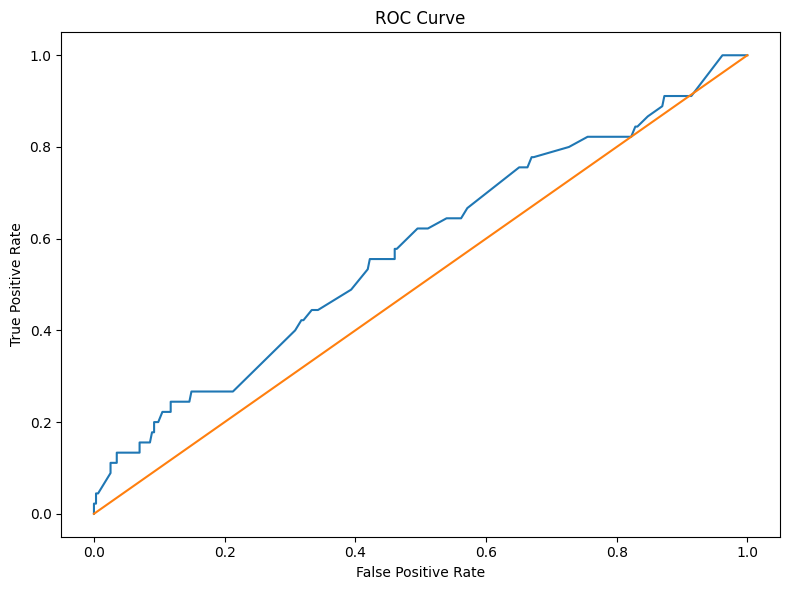

ROC-AUC: 0.5756966490299823


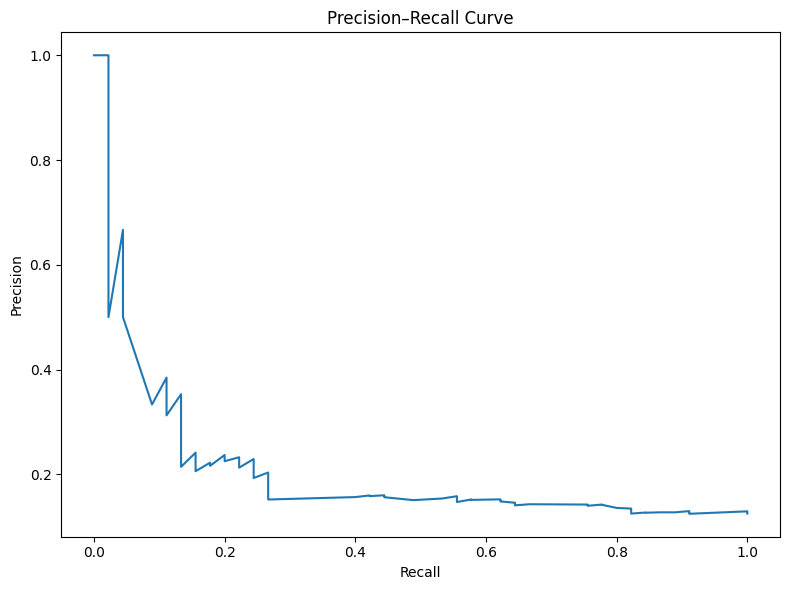

PR-AUC: 0.20396956040386344


/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/pyvenv/lib/python3.11/site-packages/sklearn/metrics/_classificati

,Threshold,Precision,Recall,F1 Score
8,0.50,0.147059,0.555556,0.232558
7,0.45,0.134545,0.822222,0.231250
6,0.40,0.128931,0.911111,0.225895
5,0.35,0.127119,1.000000,0.225564
1,0.15,0.125000,1.000000,0.222222
0,0.10,0.125000,1.000000,0.222222
4,0.30,0.125000,1.000000,0.222222
3,0.25,0.125000,1.000000,0.222222
2,0.20,0.125000,1.000000,0.222222
9,0.55,0.176471,0.266667,0.212389


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

plt.rcParams["figure.figsize"] = (8, 6)

# =========================================================
# Model Comparison
# =========================================================

comparison_rows = []

if 'models' in globals() and 'X_test' in globals() and 'y_test' in globals():
    for name, model in models.items():
        y_pred = model.predict(X_test)
        row = {
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)
        }
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
            row["ROC-AUC"] = roc_auc_score(y_test, probs)
        comparison_rows.append(row)

elif 'clf' in globals() and 'X_test' in globals() and 'y_test' in globals():
    models = {"Primary Model": clf}
    y_pred = clf.predict(X_test)
    row = {
        "Model": "Primary Model",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)[:, 1]
        row["ROC-AUC"] = roc_auc_score(y_test, probs)
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)

if not comparison_df.empty:
    sort_metric = "ROC-AUC" if "ROC-AUC" in comparison_df.columns else "F1 Score"
    comparison_df = comparison_df.sort_values(sort_metric, ascending=False)
    display(comparison_df)
else:
    print("Model comparison table could not be generated. Required variables not found.")

# =========================================================
# Best Model Diagnostics
# =========================================================

if not comparison_df.empty:
    best_model_name = comparison_df.iloc[0]["Model"]
    best_model = models[best_model_name]
    print("Selected Best Model:", best_model_name)
    
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
    
    print("\nConfusion Matrix (Counts)")
    print(cm)
    
    print("\nConfusion Matrix (Normalized)")
    print(cm_norm)
    
    # ROC Curve
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = roc_auc_score(y_test, probs)
        
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1])
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.tight_layout()
        plt.show()
        
        print("ROC-AUC:", roc_auc)
        
        # Precision–Recall Curve
        precision, recall, thresholds = precision_recall_curve(y_test, probs)
        pr_auc = auc(recall, precision)
        
        plt.figure()
        plt.plot(recall, precision)
        plt.title("Precision–Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.tight_layout()
        plt.show()
        
        print("PR-AUC:", pr_auc)
        
        # Threshold Tuning
        threshold_rows = []
        for t in np.linspace(0.1, 0.9, 17):
            preds = (probs >= t).astype(int)
            threshold_rows.append({
                "Threshold": round(t, 2),
                "Precision": precision_score(y_test, preds),
                "Recall": recall_score(y_test, preds),
                "F1 Score": f1_score(y_test, preds)
            })
        
        threshold_df = pd.DataFrame(threshold_rows)
        threshold_df = threshold_df.sort_values("F1 Score", ascending=False)
        display(threshold_df.head(10))
    
    # Feature Importance / Coefficients
    if hasattr(best_model, "feature_importances_"):
        importances = pd.Series(best_model.feature_importances_)
        importances = importances.sort_values(ascending=False).head(15)
        print("\nTop Feature Importances")
        print(importances)
    elif hasattr(best_model, "coef_"):
        coefs = pd.Series(best_model.coef_.flatten())
        coefs = coefs.sort_values(key=abs, ascending=False).head(15)
        print("\nTop Coefficients")
        print(coefs)
